### Explorative Data Analysis of Raw Dataframe
After creation of the raw dataframe with the data_gathering.py script, a look into the given data is necessary. The focus will be missing and/or implausible values, correlations and trends. Technical details on the data will be shortly discussed, as well as decisions on imputation and generation of new features for preprocessing.

In [127]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
import pandas as pd
import numpy as np

pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True,formatter={'float_kind':'{:0.2f}'.format})

df_raw = pd.read_csv('../Dataset/preprocessed_data/df_final_raw_2015_2023.csv',index_col=0,parse_dates=['date'])
df_raw.info()
display(df_raw.head())
df_raw.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 3287 entries, 0 to 3286
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             3287 non-null   datetime64[ns]
 1   03668_FD_STRAHL  3287 non-null   float64       
 2   03668_FG_STRAHL  3287 non-null   float64       
 3   03668_SD_STRAHL  3287 non-null   float64       
 4   05792_FD_STRAHL  3287 non-null   float64       
 5   05792_FG_STRAHL  3287 non-null   float64       
 6   05792_SD_STRAHL  3287 non-null   float64       
 7   05856_FD_STRAHL  3287 non-null   float64       
 8   05856_FG_STRAHL  3287 non-null   float64       
 9   05856_SD_STRAHL  3287 non-null   float64       
 10  05705_FD_STRAHL  3287 non-null   float64       
 11  05705_FG_STRAHL  3287 non-null   float64       
 12  05705_SD_STRAHL  3287 non-null   float64       
 13  02290_FD_STRAHL  3287 non-null   float64       
 14  02290_FG_STRAHL  3287 non-null   float64     

,date,03668_FD_STRAHL,03668_FG_STRAHL,03668_SD_STRAHL,05792_FD_STRAHL,05792_FG_STRAHL,05792_SD_STRAHL,05856_FD_STRAHL,05856_FG_STRAHL,05856_SD_STRAHL,...,02290_FD_STRAHL,02290_FG_STRAHL,02290_SD_STRAHL,05404_FD_STRAHL,05404_FG_STRAHL,05404_SD_STRAHL,Bruttoleistung,Nettoleistung,Prog_in_MW,Act_in_MW
0,2015-01-01,188.00,188.00,0.00,0.00,694.00,8.40,214.00,214.00,0.00,...,184.00,611.00,7.70,365.00,426.00,1.90,302.87,282.38,0.00,2807.70
1,2015-01-02,76.00,76.00,0.00,0.00,383.00,2.80,251.00,259.00,0.10,...,320.00,414.00,2.60,233.00,281.00,2.00,926.05,782.54,0.00,2813.00
2,2015-01-03,108.00,108.00,0.00,0.00,343.00,1.20,297.00,316.00,0.30,...,253.00,265.00,0.80,194.00,196.00,0.00,20.23,20.23,0.00,6713.30
3,2015-01-04,232.00,233.00,0.00,0.00,252.00,0.00,206.00,207.00,0.00,...,252.00,274.00,1.00,182.00,183.00,0.00,0.00,0.00,13422.30,4321.50
4,2015-01-05,157.00,485.00,6.20,0.00,591.00,2.90,223.00,223.00,0.00,...,279.00,457.00,3.50,344.00,392.00,1.80,502.85,476.85,18801.30,20532.60


,date,03668_FD_STRAHL,03668_FG_STRAHL,03668_SD_STRAHL,05792_FD_STRAHL,05792_FG_STRAHL,05792_SD_STRAHL,05856_FD_STRAHL,05856_FG_STRAHL,05856_SD_STRAHL,...,02290_FD_STRAHL,02290_FG_STRAHL,02290_SD_STRAHL,05404_FD_STRAHL,05404_FG_STRAHL,05404_SD_STRAHL,Bruttoleistung,Nettoleistung,Prog_in_MW,Act_in_MW
count,3287,3287.00,3287.00,3287.00,3287.00,3287.00,3287.00,3287.00,3287.00,3287.00,...,3287.00,3287.00,3287.00,3287.00,3287.00,3287.00,3287.00,3287.00,3287.00,3287.00
mean,2019-07-01 23:59:59.999999744,497.45,1168.54,-1.72,140.30,1190.96,-43.72,501.73,1183.81,-10.18,...,468.60,1221.12,-6.98,465.10,1195.08,-10.38,3491.91,3114.93,113206.85,111891.67
min,2015-01-01 00:00:00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,...,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,0.00,0.00,0.00,0.00
25%,2017-04-01 12:00:00,242.00,376.00,0.60,-999.00,638.00,0.60,271.00,421.50,0.40,...,261.00,508.00,0.80,256.00,438.50,0.70,335.00,310.18,43638.65,41035.55
50%,2019-07-02 00:00:00,467.00,1013.00,4.30,300.00,1146.00,4.90,474.00,1013.00,4.40,...,451.00,1031.00,4.80,454.00,1012.00,4.60,1085.70,991.50,105962.70,102902.40
75%,2021-09-30 12:00:00,789.00,1877.00,9.40,798.50,1865.00,8.90,765.00,1918.50,9.40,...,752.50,1917.00,9.30,771.00,1938.00,9.60,3561.81,3200.07,171325.65,171261.25
max,2023-12-31 00:00:00,1562.00,3351.00,15.70,3167.00,3553.00,16.00,1559.00,3218.00,15.70,...,1612.00,3286.00,15.50,1572.00,3271.00,15.40,118595.94,106095.63,330696.10,337090.00
std,NaN,415.57,904.43,83.86,858.26,991.40,216.87,413.89,913.37,124.25,...,474.23,887.86,111.60,478.14,911.34,125.45,6297.72,5574.79,76766.12,78022.81


> ### Further analysis for different data sources
>
> The weather data columns are having several issues, like missing and implausible values. From the data description of [DWD](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/solar/DESCRIPTION_obsgermany_climate_daily_solar_en.pdf) the value "-999" indicates missing values. The value of "0 J/cm²" in one column (05792_FD_STRAHL) is deemed to be an outlier and also removed, since it is physical unlikely, and also an obvious data gap is to be seen.
> The data from Marktstammdatenregister and Tennet have no missing values and are seemingly plausible.

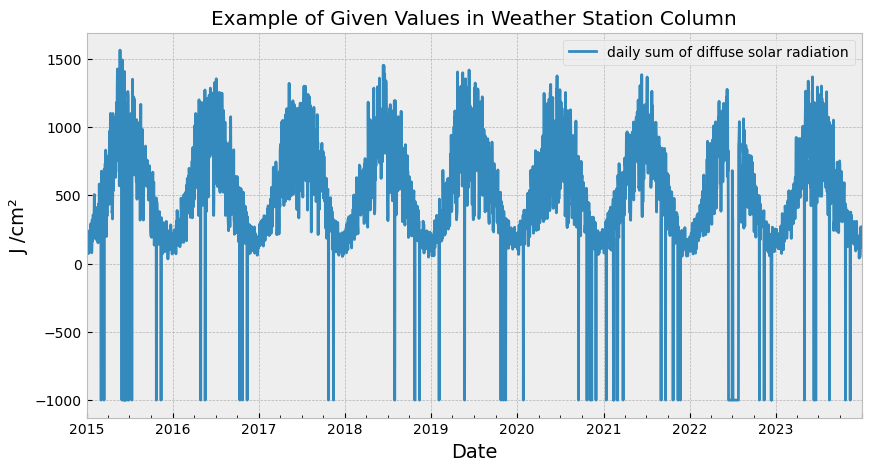

In [128]:
fig, ax = plt.subplots(figsize=(10,5))
df_raw.plot(x='date',y='03668_FD_STRAHL',figsize=(10,5),label='daily sum of diffuse solar radiation',title='Example of Given Values in Weather Station Column',ax=ax) #example of stations-file for -999 values
plt.ylabel('J /cm²',fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.show()

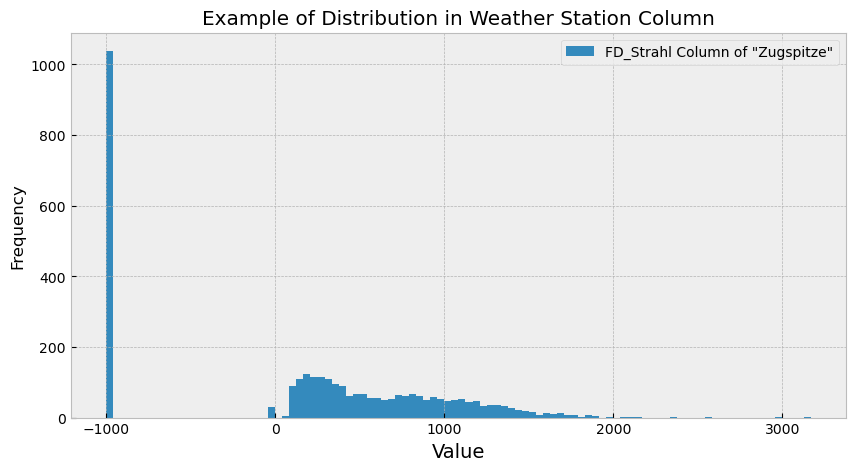

In [129]:
fig, ax = plt.subplots(figsize=(10,5))
df_raw.loc[:,'05792_FD_STRAHL'].plot(kind='hist',figsize=(10,5),bins=100,
                                     label='FD_Strahl Column of "Zugspitze"',title='Example of Distribution in Weather Station Column')
plt.xlabel('Value',fontsize=14)
ax.legend()
plt.show()
# values to be imputed: -999, 0 , since no solar radiation at all seems physically not plausible

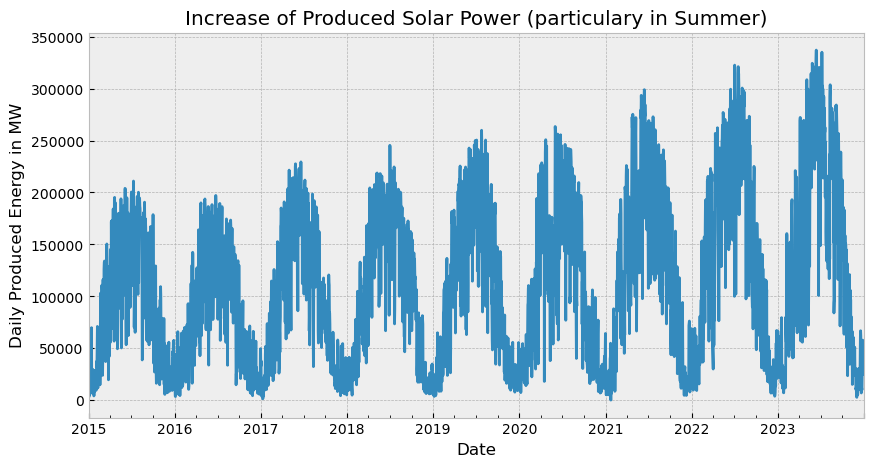

In [130]:
fig, ax = plt.subplots(figsize=(10,5))
df_raw.plot(x='date',y='Act_in_MW',figsize=(10,5),ax=ax,title='Increase of Produced Solar Power (particulary in Summer)') 
ax.get_legend().remove()
plt.ylabel('Daily Produced Energy in MW')
plt.xlabel('Date')
plt.show()

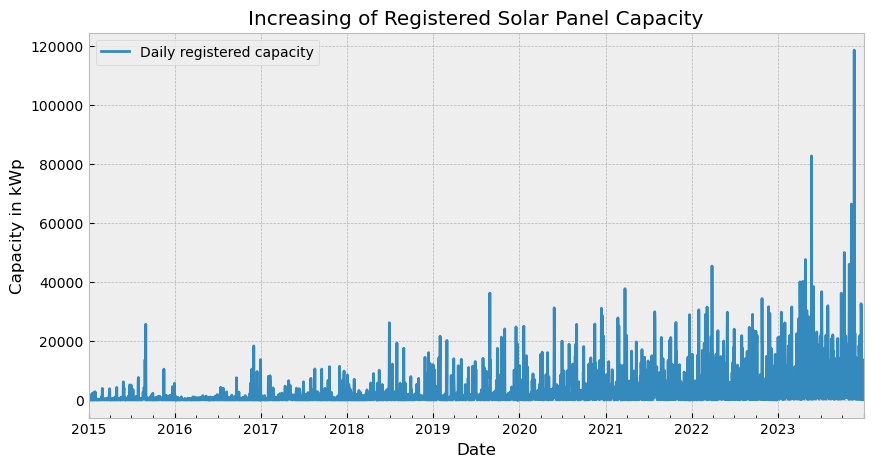

In [131]:
fig, ax = plt.subplots(figsize=(10,5))
df_raw.plot(x='date',y='Bruttoleistung',figsize=(10,5),ax=ax,title='Increasing of Registered Solar Panel Capacity',label='Daily registered capacity') 
plt.ylabel('Capacity in kWp')
plt.xlabel('Date')
plt.show()

### Preprocessing of raw data

For further usage in this project the missing values from the weather stations needs to be imputed, and new feature are needed to be engineered.

First the values will be set to pd.NA

In [151]:
df = pd.read_csv('../Dataset/preprocessed_data/df_final_raw_2015_2023.csv',index_col=0,parse_dates=['date'])

df = df.drop('Prog_in_MW',axis=1) # similar to target column, high danger of data leakage

cols_sd =[col for col in df.columns if 'SD' in col]
for col in cols_sd:
    # setting values < 0 (i.a. -999) to NaN
    df.loc[(df.loc[:,col] < 0),col] = pd.NA

cols_fd_fg = [col for col in df.columns if ('FD' in col)|('FG' in col)]
for col in cols_fd_fg:
    # setting values < 1 (-999 and 0) to NaN
    df.loc[(df.loc[:,col] < 1),col] = pd.NA

df_nan = df.loc[:,['date','05792_FG_STRAHL']].copy() # for further data analysis

df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 3287 entries, 0 to 3286
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             3287 non-null   datetime64[ns]
 1   03668_FD_STRAHL  3188 non-null   float64       
 2   03668_FG_STRAHL  3241 non-null   float64       
 3   03668_SD_STRAHL  3264 non-null   float64       
 4   05792_FD_STRAHL  2218 non-null   float64       
 5   05792_FG_STRAHL  3027 non-null   float64       
 6   05792_SD_STRAHL  3126 non-null   float64       
 7   05856_FD_STRAHL  3182 non-null   float64       
 8   05856_FG_STRAHL  3229 non-null   float64       
 9   05856_SD_STRAHL  3236 non-null   float64       
 10  05705_FD_STRAHL  3210 non-null   float64       
 11  05705_FG_STRAHL  3222 non-null   float64       
 12  05705_SD_STRAHL  3268 non-null   float64       
 13  02290_FD_STRAHL  3108 non-null   float64       
 14  02290_FG_STRAHL  3245 non-null   float64     

,date,03668_FD_STRAHL,03668_FG_STRAHL,03668_SD_STRAHL,05792_FD_STRAHL,05792_FG_STRAHL,05792_SD_STRAHL,05856_FD_STRAHL,05856_FG_STRAHL,05856_SD_STRAHL,...,05705_SD_STRAHL,02290_FD_STRAHL,02290_FG_STRAHL,02290_SD_STRAHL,05404_FD_STRAHL,05404_FG_STRAHL,05404_SD_STRAHL,Bruttoleistung,Nettoleistung,Act_in_MW
0,2015-01-01,188.00,188.00,0.00,NaN,694.00,8.40,214.00,214.00,0.00,...,0.00,184.00,611.00,7.70,365.00,426.00,1.90,302.87,282.38,2807.70
1,2015-01-02,76.00,76.00,0.00,NaN,383.00,2.80,251.00,259.00,0.10,...,0.00,320.00,414.00,2.60,233.00,281.00,2.00,926.05,782.54,2813.00
2,2015-01-03,108.00,108.00,0.00,NaN,343.00,1.20,297.00,316.00,0.30,...,0.00,253.00,265.00,0.80,194.00,196.00,0.00,20.23,20.23,6713.30
3,2015-01-04,232.00,233.00,0.00,NaN,252.00,0.00,206.00,207.00,0.00,...,0.00,252.00,274.00,1.00,182.00,183.00,0.00,0.00,0.00,4321.50
4,2015-01-05,157.00,485.00,6.20,NaN,591.00,2.90,223.00,223.00,0.00,...,7.50,279.00,457.00,3.50,344.00,392.00,1.80,502.85,476.85,20532.60


### Heatmap of data to look for correlation
Some of the weather data are highly correlating with respective columns over different stations, as it should be expected. Also, Bruttoleistung and Nettoleistung are likely the same. 

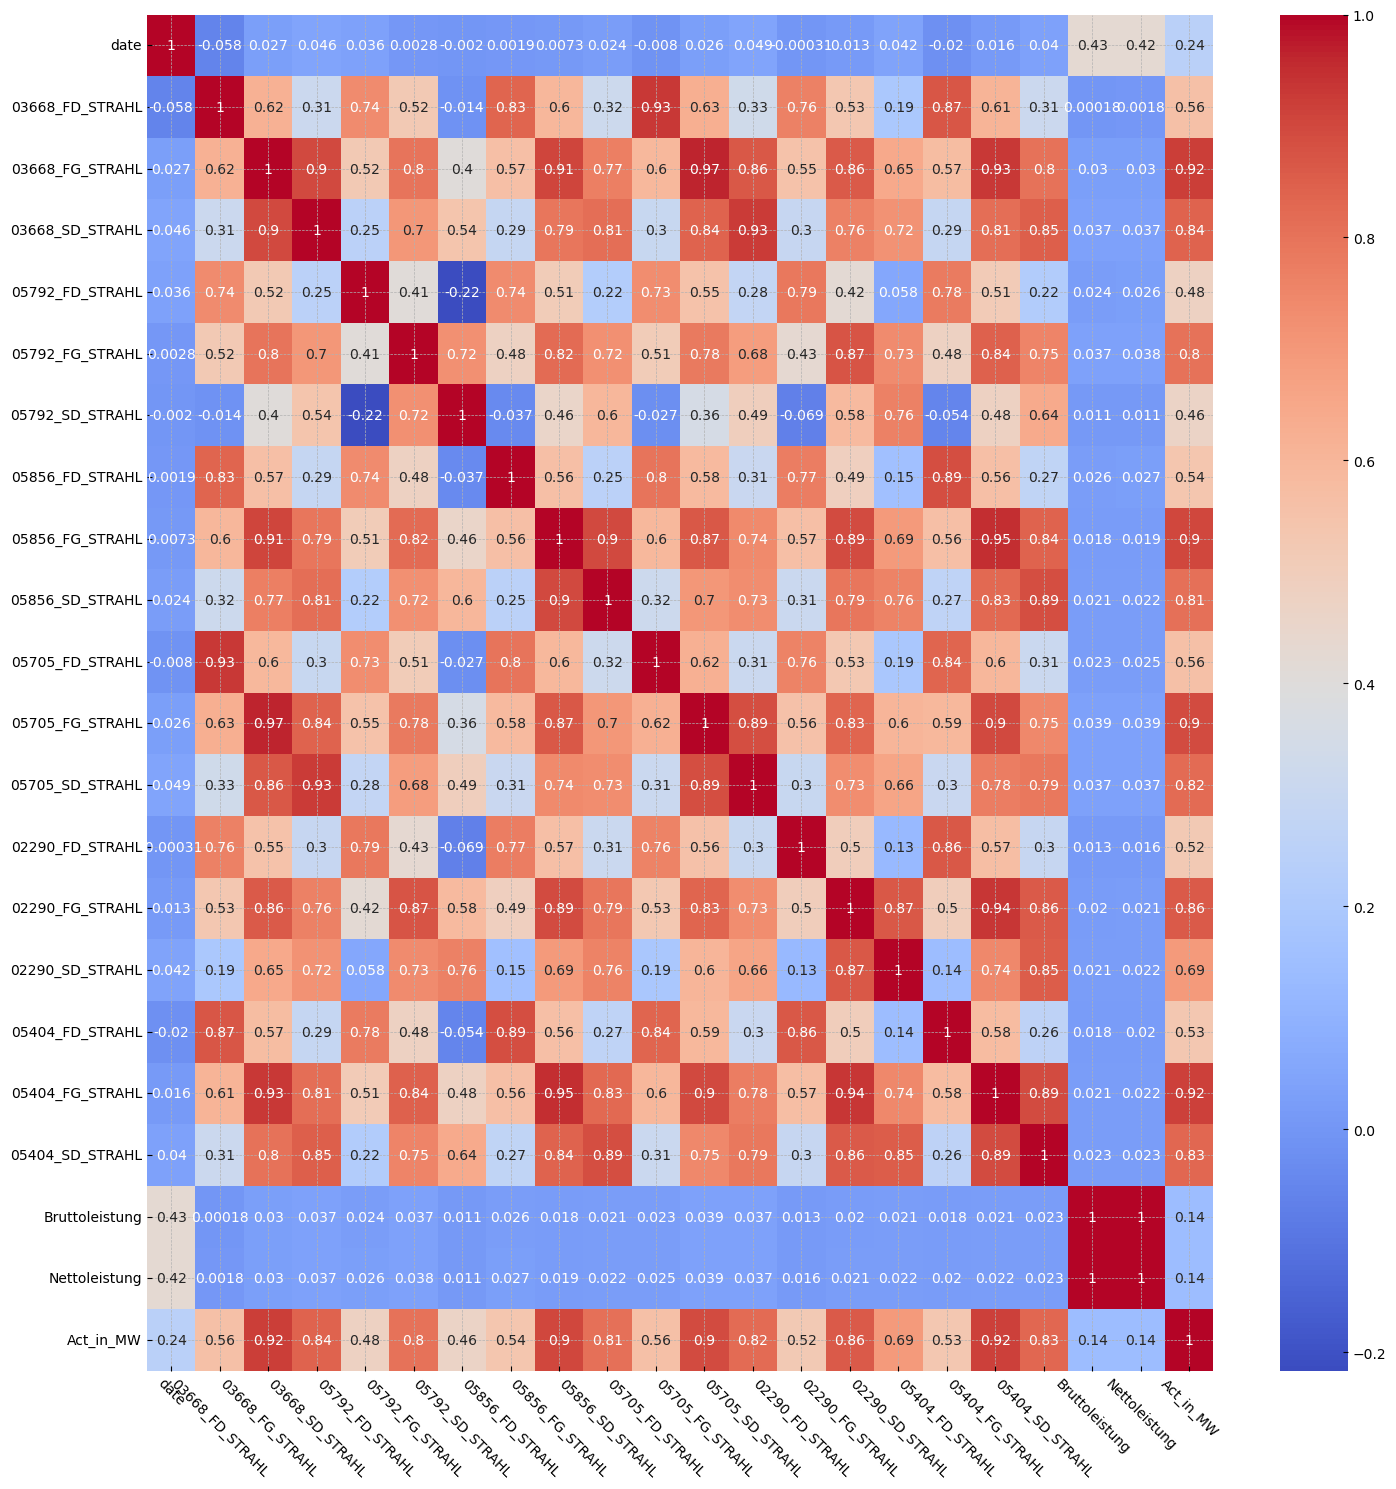

In [152]:
fig,ax=plt.subplots(figsize=(15,15))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,ax=ax)
plt.xticks(rotation=-45)  # Rotate x-axis labels for readability

plt.tight_layout()  # Adjust spacing for readability
plt.show()

Example of one column with NaN values

Slope of regression before imputation: 0.002346242714666962


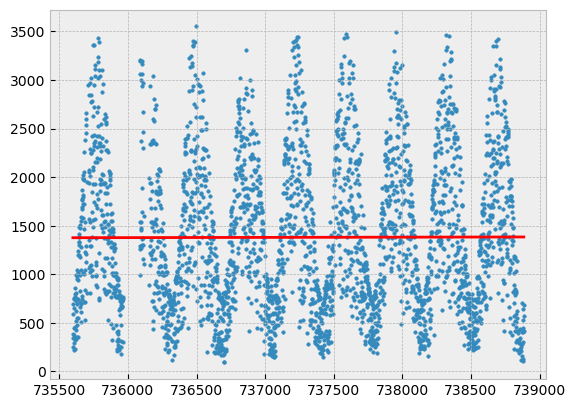

In [153]:
df_nan_plot = df_nan.copy()
df_nan_plot = df_nan_plot.dropna()
df_nan_plot.loc[:,'date']=df_nan_plot.loc[:,'date'].map(pd.Timestamp.toordinal)
xn, yn = df_nan_plot['date'],df_nan_plot['05792_FG_STRAHL']
df_nan_plot.loc[:,'date']=df_nan_plot.loc[:,'date'].map(pd.Timestamp.fromordinal)

plt.scatter(xn, yn,s=6)

#calculate equation for trendline
zn = np.polyfit(xn, yn, 1)
pn = np.poly1d(zn)

#add trendline to plot
plt.plot(xn, pn(xn),color='red')

from scipy.stats import linregress
print('Slope of regression before imputation:',linregress(xn, yn).slope)

A short overview of respective row and column for a missing value, as well as the calculation for the filling value.

In [154]:
cols_fg =[col for col in df.columns if 'FG' in col]
display(df.loc[(df['date'].dt.day==1) & (df['date'].dt.month==1),cols_fg])
print('Median of Column: ',df.loc[(df['date'].dt.day==1) & (df['date'].dt.month==1),'05792_FG_STRAHL'].median())
print('Median of Row: ',df.loc[(df.index==365) & (df['date'].dt.day==1) & (df['date'].dt.month==1),cols_fg].sum().median())
print('Mean value of both medians: ',((df.loc[(df['date'].dt.day==1) & (df['date'].dt.month==1),'05792_FG_STRAHL'].median())+(df.loc[(df.index==365) & (df['date'].dt.day==1) & (df['date'].dt.month==1),cols_fg].sum().median()))/2)

,03668_FG_STRAHL,05792_FG_STRAHL,05856_FG_STRAHL,05705_FG_STRAHL,02290_FG_STRAHL,05404_FG_STRAHL
0,188.00,694.00,214.00,129.00,611.00,426.00
365,190.00,NaN,232.00,120.00,338.00,123.00
731,499.00,730.00,454.00,131.00,641.00,395.00
1096,322.00,317.00,220.00,339.00,329.00,276.00
1461,98.00,747.00,57.00,56.00,198.00,109.00
1826,560.00,697.00,548.00,223.00,635.00,531.00
2192,144.00,663.00,448.00,185.00,397.00,418.00
2557,196.00,698.00,283.00,192.00,612.00,566.00
2922,308.00,662.00,537.00,291.00,597.00,526.00


Median of Column:  695.5
Median of Row:  156.5
Mean value of both medians:  426.0


Imputation of missing values using the **mean** value of **median** of the row (actual day and respective physical parameter) and **median** of column (respective day over the years). 
Since the outcome is acceptable, a different approach with e.g. weighted medians, especially for the station itself (=column) was skipped.

In [155]:
# imputing implausible values
r, c = np.where(df.iloc[:,:-3].isna())
for i in range(len(r)):
    # getting all SD, FG or FD columns if applicable (identical physical measurements in Bavaria)
    cols_na = [col for col in df.columns if col.endswith(str(df.columns[c[i]])[5:])]

    # getting the median of specific day from corresponding columns
    med_row = df.loc[(df.index==r[i]) & (df['date'].dt.day==(df.iloc[r[i],0].day)) & (df['date'].dt.month==(df.iloc[r[i],0].month)),cols_na].sum().median()

    # getting the median of NaN column for specific day of the year
    med_col = df.loc[(df['date'].dt.day==(df.iloc[r[i],0].day)) & (df['date'].dt.month==(df.iloc[r[i],0].month)),df.columns[c[i]]].median()
    
    # calculating mean of both medians
    mean_v = np.nanmean(np.array([med_col,med_row]))

    # imputing
    df.iloc[r[i],c[i]] = mean_v

df.isna().sum() #no values were overseen

date               0
03668_FD_STRAHL    0
03668_FG_STRAHL    0
03668_SD_STRAHL    0
05792_FD_STRAHL    0
05792_FG_STRAHL    0
05792_SD_STRAHL    0
05856_FD_STRAHL    0
05856_FG_STRAHL    0
05856_SD_STRAHL    0
05705_FD_STRAHL    0
05705_FG_STRAHL    0
05705_SD_STRAHL    0
02290_FD_STRAHL    0
02290_FG_STRAHL    0
02290_SD_STRAHL    0
05404_FD_STRAHL    0
05404_FG_STRAHL    0
05404_SD_STRAHL    0
Bruttoleistung     0
Nettoleistung      0
Act_in_MW          0
dtype: int64

Example of one column (same as above) with imputed values

Slope of regression after imputation: -0.004016395634810569


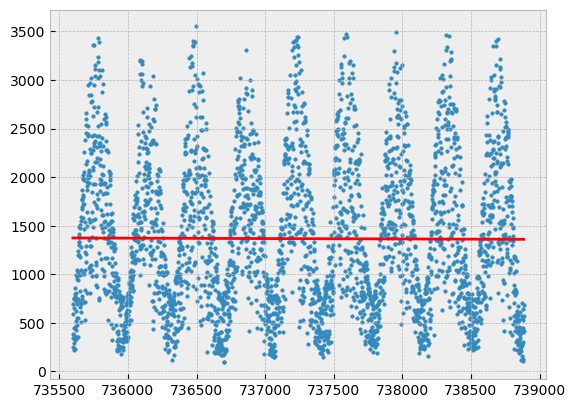

In [156]:
df.loc[:,'date']=df.loc[:,'date'].map(pd.Timestamp.toordinal)
x, y = df['date'],df['05792_FG_STRAHL']
df.loc[:,'date']=df.loc[:,'date'].map(pd.Timestamp.fromordinal)
plt.scatter(x, y,s=6)

#calculate equation for trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(x, p(x),color='red')

from scipy.stats import linregress
print('Slope of regression after imputation:',linregress(x, y).slope)

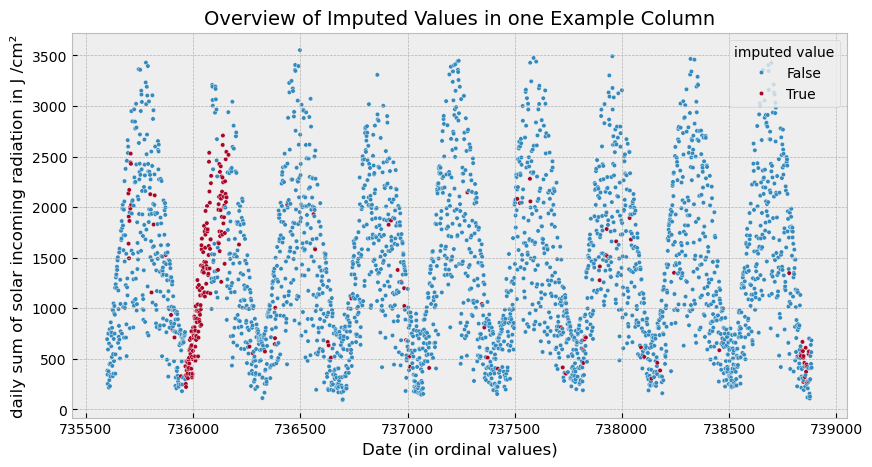

In [157]:
df_nan.loc[:,'imputed value'] = df_nan.loc[:,'05792_FG_STRAHL'].isna()
df_nan.loc[:,'05792_FG_STRAHL'] = df.loc[:,'05792_FG_STRAHL']
fig, ax = plt.subplots(figsize=(10,5))
df_nan.loc[:,'date']=df_nan.loc[:,'date'].map(pd.Timestamp.toordinal)
#xn, yn = df_nan['date'],df_nan['05792_FG_STRAHL']
sns.scatterplot(data=df_nan,x='date',y='05792_FG_STRAHL',hue='imputed value', s=10,ax=ax) #
df_nan.loc[:,'date']=df_nan.loc[:,'date'].map(pd.Timestamp.fromordinal)
plt.title('Overview of Imputed Values in one Example Column',fontsize=14)
plt.ylabel('daily sum of solar incoming radiation in J /cm²')
plt.xlabel('Date (in ordinal values)')
plt.show()

### New feature to be created: cumulative value of net- and gross production capacity

The cumulative value will show the actual capacity on each day. The base value for this calculation (values before 2015) were manually copied from the same source [Marktstammdatenregister](http://www.marktstammdatenregister.de/MaStR/Einheit/Einheiten/OeffentlicheEinheitenuebersicht?filter=Inbetriebnahmedatum%20der%20Einheit~lt~%2701.01.2015%27~and~Energietr%C3%A4ger~eq~%272495%27~and~Bundesland~eq~%271403%27)
Capacity values before 2015:
- 10.941.816 kWp gross
- 10.135.888 kWp net

Difference of the whole scripted calculation compared to automated calculation from source is less than 0.002 %, which is also explained by daily changing information on this platform.

In [158]:
# creating new features for cumulative area of solarmodules for each day
df.loc[:,'Bruttoleistung_kumulativ'] = df.loc[:,'Bruttoleistung'].cumsum()+10941816
df.loc[:,'Nettoleistung_kumulativ'] = df.loc[:,'Nettoleistung'].cumsum()+10135888

# brutto vor 2024: 22.454.441 kW
# netto vor 2024: 20.404.484 kW
print('Difference in Brutto MW of extracted data and direct information from website:',22454441-round(df.iloc[-1,-2]),'(',round((22454441-round(df.iloc[-1,-2]))/22454441,3),'%)')
print('Difference in Netto MW of extracted data and direct information from website:',20404484-round(df.iloc[-1,-1]),'(',round((20404484-round(df.iloc[-1,-1]))/20404484,3),'%)')

Difference in Brutto MW of extracted data and direct information from website: 34725 ( 0.002 %)
Difference in Netto MW of extracted data and direct information from website: 29820 ( 0.001 %)


In [159]:
# saving the preprocessed data
df.to_csv('../Dataset/preprocessed_data/df_solar_energy_2015_2023.csv')

<Axes: xlabel='date'>

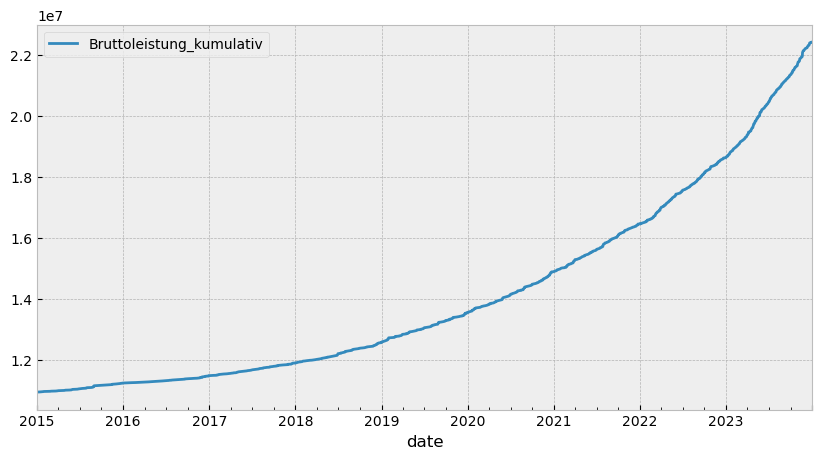

In [160]:
# development of area of solarmodules from 2015-2023
df.plot(x='date',y='Bruttoleistung_kumulativ',figsize=(10,5)) 

### Insight on trends within the data

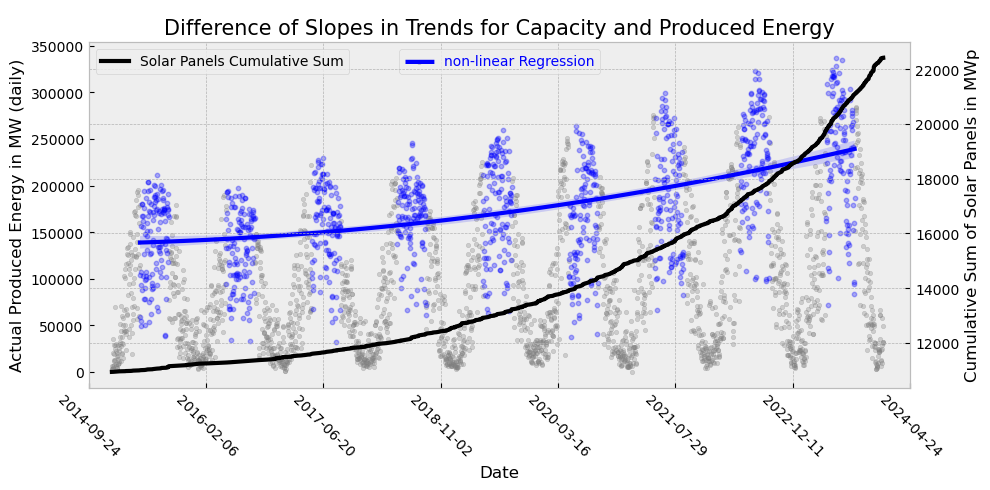

In [164]:

summer = (df['date'].dt.month <= 8) & (df['date'].dt.month >= 5)
df.loc[:,'Bruttoleistung_kumulativ'] = df.loc[:,'Bruttoleistung_kumulativ']/1000
fig, ax1 = plt.subplots(figsize=(10,5))

df.loc[:,'date']=df.loc[:,'date'].map(pd.Timestamp.toordinal) #converting date from timestamp to ordinal
df_s = df.loc[summer,:]
df.loc[~summer,:].plot.scatter(x='date',y='Act_in_MW',ax=ax1,alpha=0.3,fontsize=10,color='grey',label='non-linear Regression',s=10)
ax1.grid(visible=None, which='major', axis='y')
sns.regplot(data=df_s, x='date', y='Act_in_MW',ax=ax1, color='blue',order=2, scatter_kws={'alpha': 0.3,'s':10})
ax1.legend(loc=9,labelcolor='blue')
plt.ylabel("Actual Produced Energy in MW (daily)",fontsize=12) 
plt.xlabel("Date",fontsize=12) 
ax1.set_xlim(df.iloc[0,0], df.iloc[-1,0])
ax2 = ax1.twinx()
plt.title('Difference of Slopes in Trends for Capacity and Produced Energy',fontsize=15)
df.plot(x='date',y='Bruttoleistung_kumulativ',ax=ax2,color='black',label='Solar Panels Cumulative Sum',fontsize=10,lw=3) 
ax2.ticklabel_format(useOffset=False, style='plain')
xticks = ax1.get_xticks()
labels = [pd.Timestamp.fromordinal(int(label)).date() for label in xticks]
ax1.set_xticks(xticks)
ax1.xaxis.set_tick_params(labelrotation=-45)
ax1.set_xticklabels(labels,fontsize=10)
plt.ylabel("Cumulative Sum of Solar Panels in MWp",fontsize=12) 
df.loc[:,'date']=df.loc[:,'date'].map(pd.Timestamp.fromordinal) #converting date back to timestamp from ordinal
df.loc[:,'Bruttoleistung_kumulativ'] = df.loc[:,'Bruttoleistung_kumulativ']*1000
ax2.annotate(xy=(736750, 22700), text='_',fontsize=40,color='blue',xytext=(736850, 22700))
fig.tight_layout()
plt.show()

In [162]:
# example overview of columns
df.loc[:,['date','05404_SD_STRAHL', '05404_FD_STRAHL', '05404_FG_STRAHL', 'Act_in_MW','Bruttoleistung','Bruttoleistung_kumulativ']]

,date,05404_SD_STRAHL,05404_FD_STRAHL,05404_FG_STRAHL,Act_in_MW,Bruttoleistung,Bruttoleistung_kumulativ
0,2015-01-01,1.90,365.00,426.00,2807.70,302.87,10942118.87
1,2015-01-02,2.00,233.00,281.00,2813.00,926.05,10943044.92
2,2015-01-03,0.00,194.00,196.00,6713.30,20.23,10943065.15
3,2015-01-04,0.00,182.00,183.00,4321.50,0.00,10943065.15
4,2015-01-05,1.80,344.00,392.00,20532.60,502.85,10943567.99
...,...,...,...,...,...,...,...
3282,2023-12-27,6.10,167.00,495.00,57761.50,3113.09,22402075.68
3283,2023-12-28,2.70,258.00,324.00,31177.60,2060.98,22404136.66
3284,2023-12-29,1.60,246.00,288.00,32275.70,13647.76,22417784.42
3285,2023-12-30,4.30,272.00,465.00,49406.90,1629.46,22419413.89
